---
title: "The Condorcet Jury Theorem and Democratic Rationality"
subtitle: "Sensitivity Analysis of Failure Conditions"
categories: ["theory", "simulation", "causal inference", "sensitivity analysis"]
keep-ipynb: true
self-contained: true
draft: true
toc: true
execute: 
  freeze: auto 
  execute: true
  eval: true
jupyter: applied-bayesian-regression-modeling-env
image: 'evolving_dag.png'
author:
    - url: https://nathanielf.github.io/
    - affiliation: PyMC dev
citation: true
---


# Introduction

The Condorcet Jury Theorem offers a compelling foundation for democratic decision-making: if each member of a group is more likely than not to make the correct decision, then the majority decision becomes increasingly accurate as the group size grows. This mathematical result has profound implications for how we think about collective intelligence, from jury trials to democratic governance.

But the theorem rests on strong assumptions: voters are independent, equally competent, and better than random. What happens when these assumptions fail? In this post, we'll use Bayesian sensitivity analysis to explore the failure modes of democratic aggregation.

## Setup


In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

np.random.seed(42)

# Configuration
N_CASES = 50
N_JURORS = 15
JURY_SIZES = [3, 5, 7, 10, 15]
BLOCK_ID = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

# Part 1: Data Generation and the Ground Truth

Let's start by simulating jury voting data where we control the ground truth. We'll create a flexible simulation function that can handle both simple scenarios and more complex ones with group effects.


In [2]:
def simulate_jury_data(n_cases, n_jurors, true_p=0.65, true_discrimination=0.5, 
                       block_id=None, true_sigma_block=1.2):
    """
    Simulate jury voting data with optional block effects.
    
    Parameters:
    -----------
    n_cases : int
        Number of cases to judge
    n_jurors : int
        Number of jurors
    true_p : float
        Average competence (probability of correct vote)
    true_discrimination : float
        Standard deviation of competence in logit space
    block_id : array, optional
        Group membership for each juror (enables faction effects)
    true_sigma_block : float
        Standard deviation of block effects
        
    Returns:
    --------
    votes : (n_cases, n_jurors) array
        Binary voting matrix
    p_jurors : (n_jurors,) array
        True competence of each juror
    true_states : (n_cases,) array
        Ground truth for each case
    """
    true_states = np.random.binomial(1, 0.5, n_cases)
    
    # Simulate heterogeneous competencies in logit space
    logit_p_jurors = np.random.normal(
        np.log(true_p / (1 - true_p)), 
        true_discrimination, 
        n_jurors
    )
    
    # Add block effects if specified
    if block_id is not None:
        n_blocks = len(np.unique(block_id))
        block_effect = np.random.normal(0.0, true_sigma_block, n_blocks)
        logit_p_jurors += block_effect[block_id]
    
    p_jurors = 1 / (1 + np.exp(-logit_p_jurors))
    
    # Generate votes
    votes = np.zeros((n_cases, n_jurors))
    for i in range(n_cases):
        for j in range(n_jurors):
            prob = p_jurors[j] if true_states[i] == 1 else 1 - p_jurors[j]
            votes[i, j] = np.random.binomial(1, prob)
    
    return votes, p_jurors, true_states

# Generate our first dataset: simple case without blocks
votes, p_jurors, true_states = simulate_jury_data(N_CASES, N_JURORS)

print(f"Data simulated: {N_CASES} cases, {N_JURORS} jurors")
print(f"True average competence: {p_jurors.mean():.3f}")
print(f"Majority vote accuracy: {(votes.mean(axis=1) > 0.5).mean():.3f}")

Data simulated: 50 cases, 15 jurors
True average competence: 0.633
Majority vote accuracy: 0.520


# Part 2: Sensitivity to Prior Beliefs About Competence

Our first sensitivity analysis asks: **how much do our conclusions depend on our prior beliefs about juror competence?**

The Condorcet theorem assumes jurors are better than random (p > 0.5), but how confident should we be in this? Let's test four different prior specifications:


In [3]:
# Define prior specifications
prior_specs = {
    'weakly_informative': {
        'alpha': 3, 'beta': 2, 
        'desc': 'Weakly informative (centered at 0.6)'
    },
    'strong_competence': {
        'alpha': 10, 'beta': 5, 
        'desc': 'Strong prior (p ~ 0.67)'
    },
    'barely_competent': {
        'alpha': 6, 'beta': 5, 
        'desc': 'Skeptical prior (p ~ 0.55)'
    },
    'incompetent': {
        'alpha': 5, 'beta': 10, 
        'desc': 'Incompetent prior (p ~ 0.33)'
    },
}

Now we'll fit our base Condorcet model under each prior specification:

### Model 1: The Classical Condorcet Jury Model

Let $$T_i \in \{0,1\}$$ denote the true state of case $$i = 1,\dots,N$$, with
$$
T_i \sim \text{Bernoulli}(0.5).
$$

Each juror $j = 1,\dots,J$ casts a binary vote $V_{ij} \in \{0,1\}$.
Conditioned on the truth, all jurors share a common probability of voting correctly:
$$
\Pr(V_{ij} = T_i \mid p) = p, \qquad p > \tfrac{1}{2}.
$$

Equivalently, the likelihood may be written as:
$$
V_{ij} \mid T_i, p \sim
\begin{cases}
\text{Bernoulli}(p) & \text{if } T_i = 1, \\
\text{Bernoulli}(1-p) & \text{if } T_i = 0.
\end{cases}
$$

#### Structural Assumptions

This model imposes three strong assumptions:

1. **Exchangeability across jurors**: all jurors are equally competent.
2. **Exchangeability across cases**: all cases are equally difficult.
3. **Conditional independence**:
$$
V_{ij} \perp V_{ik} \mid T_i, p.
$$

These assumptions define the idealized world in which the Condorcet Jury Theorem applies.


In [4]:
def fit_base_condorcet_model(votes, prior_spec, n_cases=N_CASES):
    """
    Fit basic Condorcet model with specified prior on competence.
    
    This model assumes:
    - All jurors have identical competence p
    - Votes are conditionally independent given the truth
    - Equal prior probability for guilty/not guilty
    """
    with pm.Model() as model:
        # SENSITIVITY PARAMETER: Prior on competence
        p = pm.Beta('p', alpha=prior_spec['alpha'], beta=prior_spec['beta'])
        
        # Latent true state of each case
        true_state = pm.Bernoulli('true_state', p=0.5, shape=n_cases)
        
        # Voting probability depends on true state
        vote_prob = pm.Deterministic('vote_prob', pm.math.switch(
            pm.math.eq(true_state[:, None], 1), p, 1 - p
        ))
        
        pm.Bernoulli('votes', p=vote_prob, observed=votes)
        
        # Posterior predictive: majority vote accuracy for different jury sizes
        for size in [3, 7, 15]:
            votes_sim = pm.Bernoulli(f'sim_votes_{size}', p=p, shape=size)
            pm.Deterministic(
                f'majority_correct_{size}',
                pm.math.sum(votes_sim) > size / 2
            )
        
        # Sample
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(2000, tune=1000, random_seed=42,
                              target_accept=0.95, return_inferencedata=True))
        idata.extend(pm.sample_posterior_predictive(idata))
    
    return idata, model

### Prior Sensitivity in the Condorcet Model

We retain the likelihood from the classical Condorcet model but introduce uncertainty
about juror competence via a prior distribution:
$$
p \sim \text{Beta}(\alpha, \beta).
$$

No assumptions about independence or exchangeability are altered.
Instead, this model makes explicit the epistemic commitment that the Condorcet theorem leaves implicit: jurors are often assumed to be better than random *a priori*.

#### Interpretation

This modification does not change how votes are generated.
It only affects how strongly we believe in democratic competence before observing data.

If Condorcet-style aggregation fails under this model, the failure cannot be attributed to unrealistic priors — only to the structure of the voting process itself.


In [5]:
# Fit under all prior specifications
traces = {}
for prior_name, spec in prior_specs.items():
    print(f"\nFitting with {spec['desc']}...")
    idata, model = fit_base_condorcet_model(votes, spec)
    traces[prior_name] = idata
    traces[prior_name + '_model'] = model


Fitting with Weakly informative (centered at 0.6)...


Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]



Fitting with Strong prior (p ~ 0.67)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]



Fitting with Skeptical prior (p ~ 0.55)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]



Fitting with Incompetent prior (p ~ 0.33)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Let's examine how our prior beliefs influence predictions:


In [6]:
def extract_estimates(traces, prior_specs, jury_sizes=[3, 7, 15], stage='prior'):
    """Extract majority accuracy estimates from traces."""
    ests = {}
    for prior_name in prior_specs.keys():
        estimates = []
        for size in jury_sizes:
            p = traces[prior_name][stage][f'majority_correct_{size}'].mean().item()
            estimates.append(p)
        ests[prior_name] = estimates
    
    return pd.DataFrame(
        ests, 
        index=[f'Correct % for Majority of {s}' for s in jury_sizes]
    )

# Compare prior and posterior estimates
prior_estimates = extract_estimates(traces, prior_specs, stage='prior')
posterior_estimates = extract_estimates(traces, prior_specs, stage='posterior')

print("\n" + "="*70)
print("PRIOR ESTIMATES")
print("="*70)
print(prior_estimates)

print("\n" + "="*70)
print("POSTERIOR ESTIMATES (AFTER SEEING DATA)")
print("="*70)
print(posterior_estimates)


PRIOR ESTIMATES
                              weakly_informative  strong_competence  \
Correct % for Majority of 3                0.610              0.718   
Correct % for Majority of 7                0.648              0.766   
Correct % for Majority of 15               0.710              0.830   

                              barely_competent  incompetent  
Correct % for Majority of 3              0.560        0.292  
Correct % for Majority of 7              0.546        0.228  
Correct % for Majority of 15             0.554        0.182  

POSTERIOR ESTIMATES (AFTER SEEING DATA)
                              weakly_informative  strong_competence  \
Correct % for Majority of 3               0.5380           0.591875   
Correct % for Majority of 7               0.5485           0.637375   
Correct % for Majority of 15              0.5620           0.672500   

                              barely_competent  incompetent  
Correct % for Majority of 3           0.475250     0.381875  


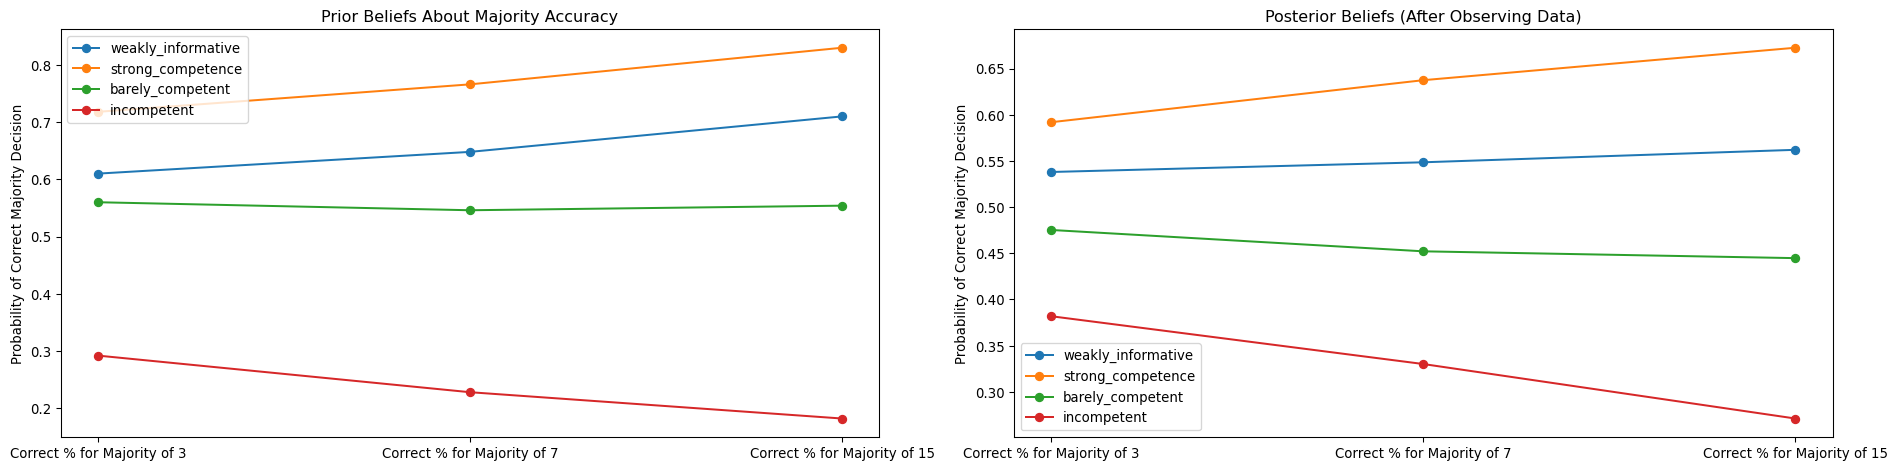

In [7]:
# Visualize the shift from prior to posterior
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for prior_name in prior_specs.keys():
    axs[0].plot(prior_estimates.index, prior_estimates[prior_name], 
                label=prior_name, marker='o')
    axs[1].plot(posterior_estimates.index, posterior_estimates[prior_name], 
                label=prior_name, marker='o')

axs[0].legend()
axs[1].legend()
axs[0].set_title("Prior Beliefs About Majority Accuracy")
axs[1].set_title("Posterior Beliefs (After Observing Data)")
axs[0].set_ylabel("Probability of Correct Majority Decision")
axs[1].set_ylabel("Probability of Correct Majority Decision")

plt.tight_layout()
plt.show()

**Key insight**: Strong prior beliefs about incompetence, the data updates our beliefs away from the truth. You cannot avoid the requirement of minimum competence in the jury pool.

# Part 3: Individual Differences in Competence

The base Condorcet model assumes all jurors are identically competent. In reality, people vary in expertise, attention, and judgment. Let's model **heterogeneity** in juror competence.

## The Hierarchical Model

We'll use a hierarchical model where individual competencies are drawn from a population distribution. The key sensitivity parameter is σ (discrimination): how much do jurors differ?

### Heterogeneous Juror Competence

We now relax the assumption that all jurors are equally competent.

Each juror $j$ is assigned an individual probability of voting correctly:
$$
\text{logit}(p_j) = \mu + \sigma z_j, \qquad z_j \sim \mathcal{N}(0,1).
$$

### Collapsing Bernoulli Votes to a Binomial Likelihood

For a fixed juror $j$, define the number of agreements with the majority:
$$
A_j = \sum_{i=1}^N \mathbb{1}\{V_{ij} = \text{majority}_i\}.
$$

Under the assumption that cases are exchangeable and votes are conditionally independent given $p_j$, we obtain the exact likelihood:

$$
A_j \mid p_j \sim \text{Binomial}(N, p_j).
$$

This is not an approximation.
It is the marginal likelihood obtained by integrating over $$N$$ independent Bernoulli trials:
$$
\prod_{i=1}^N \text{Bernoulli}(V_{ij} \mid p_j)
\;\Longrightarrow\;
\text{Binomial}(A_j \mid N, p_j).
$$

#### Structural Interpretation

The Binomial likelihood relies on two assumptions:

1. **Exchangeability across cases**
2. **Sufficiency of the count statistic**

Once jurors are treated as stable measurement instruments, their entire voting history becomes a single aggregated observation. This collapse will fail as soon as cases are no longer interchangeable.


In [8]:
def fit_hierarchical_model(votes, n_jurors, discrimination_prior):
    """
    Fit hierarchical model with individual variation in competence.
    
    Model structure:
    - μ: population mean competence (in logit space)
    - σ: population standard deviation (SENSITIVITY PARAMETER)
    - Each juror has individual competence drawn from N(μ, σ)
    
    We use non-centered parameterization for better sampling.
    """
    majority_votes = (votes.mean(axis=1) > 0.5).astype(int)
    agreements_per_juror = np.array([
        (votes[:, j] == majority_votes).sum() for j in range(n_jurors)
    ])
    
    with pm.Model() as model:
        # Population-level parameters
        mu_logit_p = pm.Normal('mu_logit_p', mu=0.6, sigma=0.5)
        
        # KEY SENSITIVITY PARAMETER: individual discrimination
        sigma_logit_p = pm.HalfNormal(
            'sigma_logit_p', 
            sigma=discrimination_prior['sigma']
        )
        
        # Non-centered parameterization: logit_p = μ + σ * z
        z_juror = pm.Normal('z_juror', mu=0, sigma=1, shape=n_jurors)
        logit_p_juror = pm.Deterministic(
            'logit_p_juror', 
            mu_logit_p + sigma_logit_p * z_juror
        )
        p_juror = pm.Deterministic('p_juror', pm.math.invlogit(logit_p_juror))
        
        # Collapsed likelihood: count agreements with majority
        pm.Binomial('agreements', n=N_CASES, p=p_juror, 
                   observed=agreements_per_juror)
        
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(1000, tune=2000, random_seed=42,
                              target_accept=0.95, return_inferencedata=True,
                              idata_kwargs={"log_likelihood": True}))
        idata.extend(pm.sample_posterior_predictive(idata))
    
    return idata, model


In [9]:
# Test three levels of discrimination
discrimination_priors = {
    'weak_discrimination': {
        'sigma': 0.5, 
        'desc': 'Weak discrimination (σ ~ 0.25)'
    },
    'moderate_discrimination': {
        'sigma': 1.0, 
        'desc': 'Moderate discrimination (σ ~ 0.5)'
    },
    'strong_discrimination': {
        'sigma': 2.0, 
        'desc': 'Strong discrimination (σ ~ 2)'
    },
}

traces_discrimination = {}
for prior_name, spec in discrimination_priors.items():
    print(f"\nFitting with {spec['desc']}...")
    idata, model = fit_hierarchical_model(votes, N_JURORS, spec)
    traces_discrimination[prior_name] = idata
    traces_discrimination[prior_name + '_model'] = model

# Examine one of the fitted models
az.summary(traces_discrimination['moderate_discrimination'])


Fitting with Weak discrimination (σ ~ 0.25)...


Sampling: [agreements, mu_logit_p, sigma_logit_p, z_juror]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_logit_p, sigma_logit_p, z_juror]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Sampling: [agreements]


Output()

Sampling: [agreements, mu_logit_p, sigma_logit_p, z_juror]


Initializing NUTS using jitter+adapt_diag...



Fitting with Moderate discrimination (σ ~ 0.5)...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_logit_p, sigma_logit_p, z_juror]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Sampling: [agreements]


Output()

Sampling: [agreements, mu_logit_p, sigma_logit_p, z_juror]


Initializing NUTS using jitter+adapt_diag...



Fitting with Strong discrimination (σ ~ 2)...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_logit_p, sigma_logit_p, z_juror]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Sampling: [agreements]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_logit_p,0.553,0.115,0.331,0.770,0.002,0.002,2379.0,2332.0,1.0
z_juror[0],-0.214,0.725,-1.546,1.167,0.010,0.013,5280.0,3005.0,1.0
z_juror[1],0.170,0.743,-1.218,1.578,0.011,0.013,4184.0,2638.0,1.0
z_juror[2],0.322,0.746,-1.128,1.702,0.010,0.014,5658.0,3040.0,1.0
z_juror[3],-0.356,0.724,-1.695,1.055,0.011,0.012,4743.0,3099.0,1.0
z_juror[4],-0.227,0.737,-1.662,1.117,0.011,0.015,4535.0,2499.0,1.0
z_juror[5],-0.220,0.713,-1.570,1.116,0.010,0.013,5191.0,2816.0,1.0
z_juror[6],0.051,0.728,-1.281,1.499,0.010,0.013,5371.0,3175.0,1.0
z_juror[7],0.873,0.762,-0.556,2.323,0.012,0.014,4139.0,2546.0,1.0
z_juror[8],0.318,0.732,-1.114,1.659,0.010,0.012,5206.0,2968.0,1.0


## Posterior Predictive Checks

To understand the implications of different discrimination levels, we need to simulate complete jury deliberations. We need to translate our individual voter's profile into votes. As before votes are generated as, but we have no longer directly modelled this outcome, so we derive implied votes through posterior predictive checks. 
$$
V_{ij} \mid T_i, p_j \sim
\begin{cases}
\text{Bernoulli}(p_j) & \text{if } T_i = 1, \\
\text{Bernoulli}(1-p_j) & \text{if } T_i = 0.
\end{cases}
$$

#### Structural Consequences

Conditional independence is preserved, but only after conditioning on individual competence:
$$
V_{ij} \perp V_{ik} \mid T_i, \{p_j\}.
$$

This model introduces inequality among jurors without introducing dependence.
Heterogeneous competence alone does not violate the conditions of the Condorcet theorem. Here's our comprehensive PPC framework:


In [10]:
def simulate_votes_from_competence(p_juror, n_cases, truth=None):
    """Generate votes given juror competencies and ground truth."""
    n_jurors = len(p_juror)
    if truth is None:
        truth = np.random.binomial(1, 0.5, size=n_cases)
    
    votes = np.zeros((n_cases, n_jurors), dtype=int)
    for i in range(n_cases):
        for j in range(n_jurors):
            prob = p_juror[j] if truth[i] == 1 else 1 - p_juror[j]
            votes[i, j] = np.random.binomial(1, prob)
    
    return truth, votes


def compute_diagnostics(votes, truth):
    """Compute suite of diagnostic metrics for jury performance."""
    majority = votes.mean(axis=1) > 0.5
    
    diagnostics = {
        'majority_accuracy': np.mean(majority == truth),
        'unanimity_rate': np.mean(
            (votes.sum(axis=1) == 0) | (votes.sum(axis=1) == votes.shape[1])
        ),
        'juror_agreement': np.mean(votes == truth[:, None], axis=0),
    }
    
    # Error correlation: do jurors make mistakes together?
    errors = votes != truth[:, None]
    if errors.var(axis=0).sum() > 0:
        diagnostics['error_corr'] = np.corrcoef(errors.T)
    else:
        diagnostics['error_corr'] = np.zeros((votes.shape[1], votes.shape[1]))
    
    return diagnostics


def majority_accuracy_by_size(votes, truth, jury_size):
    """Calculate accuracy for random sub-juries of given size."""
    n_cases, n_jurors = votes.shape
    correct = np.zeros(n_cases, dtype=int)
    
    for i in range(n_cases):
        jurors = np.random.choice(n_jurors, size=jury_size, replace=False)
        majority = votes[i, jurors].mean() > 0.5
        correct[i] = (majority == truth[i])
    
    return correct.mean()


def run_ppc_analysis(idata, n_cases, truth, jury_sizes=JURY_SIZES):
    """Run comprehensive posterior predictive checks."""
    p_juror_samples = (idata.posterior['p_juror']
                      .stack(sample=("chain", "draw")).values)
    n_jurors, n_samples = p_juror_samples.shape
    
    results = {
        'majority_acc': np.zeros(n_samples),
        'unanimity': np.zeros(n_samples),
        'error_corr': np.zeros((n_samples, n_jurors, n_jurors)),
        'accuracy_by_size': {k: np.zeros(n_samples) for k in jury_sizes}
    }
    
    for s in range(n_samples):
        _, votes = simulate_votes_from_competence(
            p_juror_samples[:, s], n_cases, truth
        )
        diag = compute_diagnostics(votes, truth)
        
        results['majority_acc'][s] = diag['majority_accuracy']
        results['unanimity'][s] = diag['unanimity_rate']
        results['error_corr'][s] = diag['error_corr']
        
        for k in jury_sizes:
            results['accuracy_by_size'][k][s] = (
                majority_accuracy_by_size(votes, truth, k)
            )
    
    return results


def summarize_ppc(ppc_results, jury_sizes=JURY_SIZES):
    """Create summary DataFrame from PPC results."""
    percentiles = [5, 50, 95]
    summaries = []
    
    for k in jury_sizes:
        summaries.append(np.percentile(
            ppc_results['accuracy_by_size'][k], percentiles
        ))
    
    df = pd.DataFrame(summaries).T
    df.columns = [f'majority_accuracy_{k}' for k in jury_sizes]
    df.index = [f'percentile_{p}' for p in percentiles]
    
    return df


def compare_prior_posterior(idata, n_cases, truth, jury_sizes=JURY_SIZES):
    """Compare prior and posterior predictive distributions."""
    results = {}
    
    for stage in ['prior', 'posterior']:
        p_samples = (getattr(idata, stage)['p_juror']
                    .stack(sample=("chain", "draw")).values)
        n_jurors, n_samples = p_samples.shape
        
        # Simplified PPC for comparison
        stage_results = {k: np.zeros(n_samples) for k in jury_sizes}
        for s in range(n_samples):
            _, votes = simulate_votes_from_competence(
                p_samples[:, s], n_cases, truth
            )
            for k in jury_sizes:
                stage_results[k][s] = majority_accuracy_by_size(votes, truth, k)
        
        results[stage] = summarize_ppc({'accuracy_by_size': stage_results}, 
                                      jury_sizes)
    
    return pd.concat(results, names=['stage', 'percentile'])

Now let's apply this framework. We'll focus on the moderate discrimination case as it's most realistic:



Analysis: Moderate discrimination (σ ~ 0.5)


                         majority_accuracy_3  majority_accuracy_5  \
stage     percentile                                                
prior     percentile_5                 0.360                 0.34   
          percentile_50                0.700                 0.76   
          percentile_95                0.901                 0.96   
posterior percentile_5                 0.580                 0.62   
          percentile_50                0.700                 0.74   
          percentile_95                0.800                 0.84   

                         majority_accuracy_7  majority_accuracy_10  \
stage     percentile                                                 
prior     percentile_5                  0.30                  0.32   
          percentile_50                 0.79                  0.83   
          percentile_95                 0.98                  1.00   
posterior percentile_5                  0.66                  0.70   
          percentile_50    

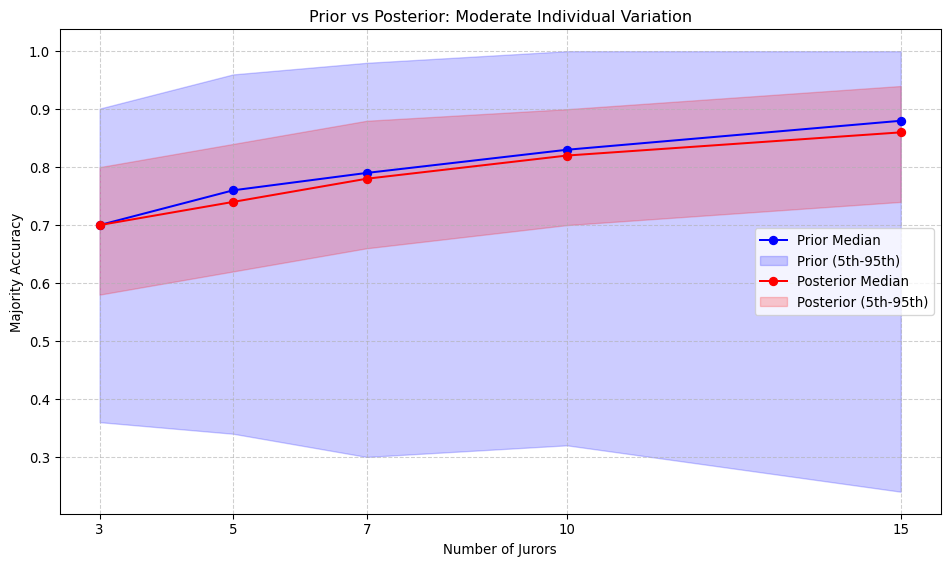

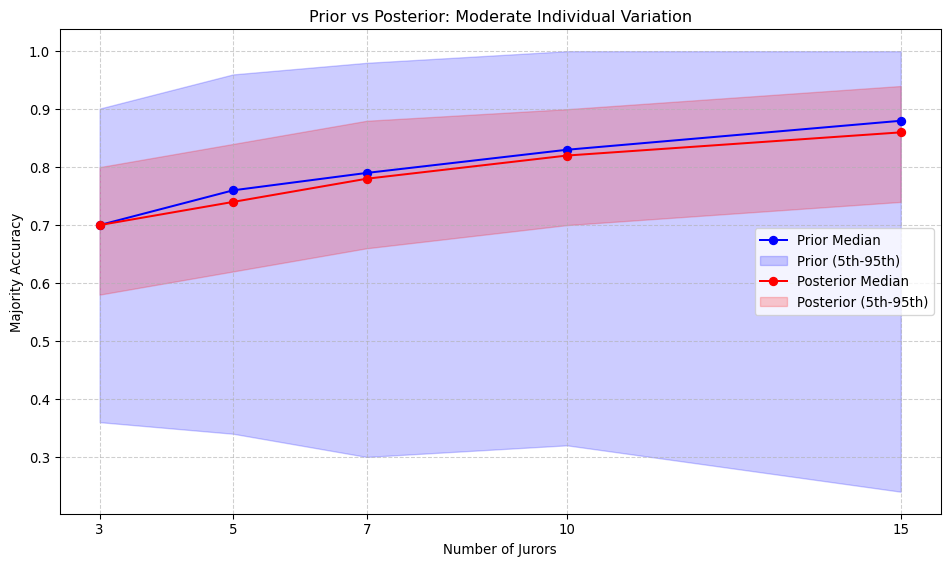

In [11]:
def plot_prior_posterior_comparison(df, title="Majority Accuracy"):
    """Plot prior vs posterior distributions."""
    x_values = JURY_SIZES
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for stage, color in [('prior', 'blue'), ('posterior', 'red')]:
        median = df.loc[(stage, 'percentile_50')]
        low = df.loc[(stage, 'percentile_5')]
        high = df.loc[(stage, 'percentile_95')]
        
        ax.plot(x_values, median, label=f'{stage.title()} Median', 
                color=color, marker='o')
        ax.fill_between(x_values, low, high, color=color, alpha=0.2,
                       label=f'{stage.title()} (5th-95th)')
    
    ax.set_title(title)
    ax.set_xlabel('Number of Jurors')
    ax.set_ylabel('Majority Accuracy')
    ax.set_xticks(x_values)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    return fig


# Analyze the moderate discrimination case
print(f"\n{'='*70}")
print(f"Analysis: {discrimination_priors['moderate_discrimination']['desc']}")
print('='*70)

comparison = compare_prior_posterior(
    traces_discrimination['moderate_discrimination'], 
    N_CASES, 
    true_states
)

print(comparison)
plot_prior_posterior_comparison(
    comparison, 
    title="Prior vs Posterior: Moderate Individual Variation"
)

The pattern is consistent across all discrimination levels: the data updates our beliefs, and larger juries show higher accuracy. The key question is whether errors remain independent.


## Error Correlation Analysis

A critical assumption of Condorcet is **independence**: jurors make errors independently. Let's check this for our moderate discrimination model:


/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Error Correlation Summary:
{'mean_off_diag': np.float64(4.1269912183272494e-05), 'sd_off_diag': np.float64(0.14293965923889015), 'p95_abs_corr': np.float64(0.2792611296287719)}


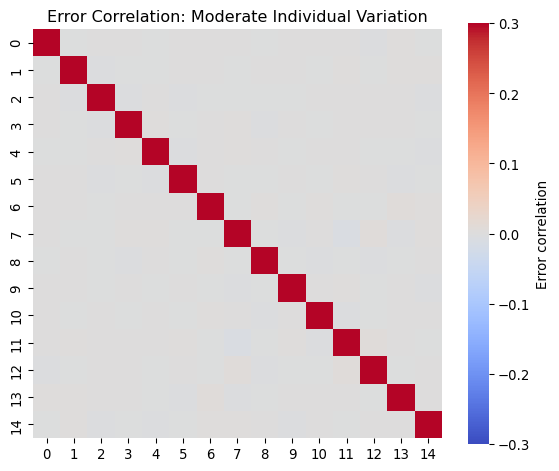

In [12]:
def plot_error_correlation_heatmap(ppc_results, title="Error Correlation"):
    """Plot mean error correlation matrix, handling NaN values properly."""
    all_corrs = ppc_results['error_corr']  # (n_samples, n_jurors, n_jurors)
    
    # Use nanmean to properly average across samples, ignoring NaNs
    mean_corr = np.nanmean(all_corrs, axis=0)
    
    # For cells that are still NaN (all samples were NaN), replace with 0
    mean_corr = np.nan_to_num(mean_corr, nan=0.0)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(mean_corr, vmin=-0.3, vmax=0.3, cmap="coolwarm",
                square=True, cbar_kws={"label": "Error correlation"}, ax=ax)
    ax.set_title(title)
    plt.tight_layout()
    return fig


def summarize_error_correlation(ppc_results):
    """Extract summary statistics from error correlation matrices."""
    corr = ppc_results['error_corr']
    n = corr.shape[1]
    
    off_diag = []
    for s in range(corr.shape[0]):
        mat = corr[s]
        # Extract upper triangle (excluding diagonal)
        upper_tri = mat[np.triu_indices(n, k=1)]
        # Only include non-NaN values
        valid_values = upper_tri[~np.isnan(upper_tri)]
        if len(valid_values) > 0:
            off_diag.extend(valid_values)
    
    off_diag = np.array(off_diag)
    
    if len(off_diag) == 0:
        return {
            'mean_off_diag': np.nan,
            'sd_off_diag': np.nan,
            'p95_abs_corr': np.nan,
        }
    
    return {
        'mean_off_diag': off_diag.mean(),
        'sd_off_diag': off_diag.std(),
        'p95_abs_corr': np.percentile(np.abs(off_diag), 95),
    }


ppc_moderate = run_ppc_analysis(
    traces_discrimination['moderate_discrimination'], 
    N_CASES, 
    true_states
)

plot_error_correlation_heatmap(
    ppc_moderate, 
    title="Error Correlation: Moderate Individual Variation"
)

print("\nError Correlation Summary:")
print(summarize_error_correlation(ppc_moderate))

**Key insight**: With heterogeneous competence alone, errors remain largely uncorrelated (mean ≈ 0). The Condorcet theorem's independence assumption holds—so far.

# Part 4: Shared Case Difficulty

Now we introduce a critical violation: **shared case-level effects**. Some cases are genuinely harder, causing even competent jurors to fail together.

To properly explore this, we need to do posterior predictive sampling that includes case difficulty in the generative model. 

### Simulating Shared Case Shocks

We now introduce case-level difficulty effects:
$$
\delta_i \sim \mathcal{N}(0, \sigma_{\text{case}}).
$$

Votes are generated according to:
$$
\text{logit}\,\Pr(V_{ij} = T_i)
= \alpha_j + \delta_i.
$$

#### Structural Consequences

Votes for the same case now share a common latent influence.
As a result:
$$
V_{ij} \not\!\perp V_{ik} \mid T_i, \alpha_j.
$$

Cases are no longer exchangeable, and the Binomial likelihood is no longer valid.
This violation produces correlated errors across jurors and directly undermines
the Condorcet theorem.


In [13]:
def ppc_with_case_difficulty(idata, model, n_cases_sim, sigma_case_values, 
                            true_states=None, n_draws=500):
    """
    Posterior predictive checks with shared case-level difficulty effects.
    
    This properly samples from the posterior predictive distribution,
    including uncertainty in juror competencies.
    """
    if true_states is None:
        true_states = np.random.binomial(1, 0.5, size=n_cases_sim)
    
    results = {}
    
    for sigma_case in sigma_case_values:
        with model:
            # Get posterior samples of logit_p_juror
            logit_p_trace = idata.posterior['logit_p_juror']
            n_jurors = logit_p_trace.shape[-1]
            
            # Sample from posterior predictive with case difficulty
            # For each posterior sample, generate new votes with case effects
            pm.set_data({'n_cases_ppc': n_cases_sim})
            
            # Case difficulty effects (shared across jurors)
            delta_case = pm.Normal('delta_case', mu=0, sigma=sigma_case, 
                                  shape=n_cases_sim)
            
            # Generate votes for each case and juror
            votes_list = []
            for i in range(n_cases_sim):
                truth_i = true_states[i]
                sign = 1 if truth_i == 1 else -1
                
                # Competence + case difficulty
                logit_p_case = sign * logit_p_trace + delta_case[i]
                p_case = pm.math.sigmoid(logit_p_case)
                
                # This will be shape (chain, draw, n_jurors)
                votes_i = pm.Bernoulli(f'votes_case_{i}', p=p_case)
                votes_list.append(votes_i)
            
            # Sample from posterior predictive
            ppc = pm.sample_posterior_predictive(
                idata, 
                var_names=[f'votes_case_{i}' for i in range(n_cases_sim)] + ['delta_case'],
                predictions=True,
                random_seed=42
            )
        
        # Reorganize votes into (sample, case, juror) array
        n_samples = n_draws
        votes_array = np.zeros((n_samples, n_cases_sim, n_jurors), dtype=int)
        
        for i in range(n_cases_sim):
            votes_case = ppc.predictions[f'votes_case_{i}'].values
            # Flatten chain and draw dimensions
            votes_flat = votes_case.reshape(-1, n_jurors)[:n_samples]
            votes_array[:, i, :] = votes_flat
        
        # Calculate diagnostics
        acc = []
        corrs = []
        
        for s in range(n_samples):
            majority = votes_array[s].mean(axis=1) > 0.5
            acc.append((majority == true_states).mean())
            
            errors = votes_array[s] != true_states[:, None]
            if errors.var(axis=0).sum() > 0:
                C = np.corrcoef(errors.T)
                corrs.append(C)
        
        corrs = np.stack(corrs) if corrs else np.zeros((1, n_jurors, n_jurors))
        off_diag = corrs[:, ~np.eye(n_jurors, dtype=bool)]
        
        results[sigma_case] = {
            'accuracy': acc,
            'mean_accuracy': np.mean(acc),
            'error_corr': corrs,
            'mean_corr': np.nanmean(off_diag),
            'median_corr': np.nanmedian(off_diag),
            'p95_abs_corr': np.nanpercentile(np.abs(off_diag), 95)
        }
    
    return results


# Simpler approach: directly simulate from posterior samples
def simple_case_difficulty_ppc(idata, n_cases_sim, sigma_case_values, 
                               true_states=None, n_draws=500):
    """
    Simplified PPC that samples logit_p from posterior then adds case effects.
    """
    if true_states is None:
        true_states = np.random.binomial(1, 0.5, size=n_cases_sim)
    
    # Get posterior samples
    logit_p_samples = (idata.posterior['logit_p_juror']
                      .stack(sample=("chain", "draw")).values)
    n_jurors, total_samples = logit_p_samples.shape
    
    # Randomly select n_draws samples
    sample_idx = np.random.choice(total_samples, size=n_draws, replace=False)
    logit_p_samples = logit_p_samples[:, sample_idx]
    
    results = {}
    
    for sigma_case in sigma_case_values:
        votes_array = np.zeros((n_draws, n_cases_sim, n_jurors), dtype=int)
        
        for s in range(n_draws):
            # Sample case difficulty effects
            delta_case = np.random.normal(0, sigma_case, size=n_cases_sim)
            
            for i in range(n_cases_sim):
                truth_i = true_states[i]
                sign = 1 if truth_i == 1 else -1
                
                # Apply case difficulty to all jurors
                logit_p_case = sign * logit_p_samples[:, s] + delta_case[i]
                p_case = 1 / (1 + np.exp(-logit_p_case))
                
                votes_array[s, i, :] = np.random.binomial(1, p_case)
        
        # Calculate diagnostics
        acc = []
        corrs = []
        
        for s in range(n_draws):
            majority = votes_array[s].mean(axis=1) > 0.5
            acc.append((majority == true_states).mean())
            
            errors = votes_array[s] != true_states[:, None]
            if errors.var(axis=0).sum() > 0:
                C = np.corrcoef(errors.T)
                corrs.append(C)
        
        corrs = np.stack(corrs) if corrs else np.zeros((1, n_jurors, n_jurors))
        off_diag = corrs[:, ~np.eye(n_jurors, dtype=bool)]
        
        results[sigma_case] = {
            'accuracy': acc,
            'mean_accuracy': np.mean(acc),
            'error_corr': corrs,
            'mean_corr': np.nanmean(off_diag),
            'median_corr': np.nanmedian(off_diag),
            'p95_abs_corr': np.nanpercentile(np.abs(off_diag), 95)
        }
    
    return results


print("="*70)
print("IMPACT OF SHARED CASE DIFFICULTY")
print("="*70)

sigma_values = [0.0, 0.2, 0.5, 1.0]
case_diff_results = simple_case_difficulty_ppc(
    traces_discrimination['weak_discrimination'],
    n_cases_sim=N_CASES,
    sigma_case_values=sigma_values,
    true_states=true_states,
    n_draws=500
)

for sigma in sigma_values:
    res = case_diff_results[sigma]
    print(f"\nσ_case = {sigma}")
    print(f"  Mean majority accuracy: {res['mean_accuracy']:.3f}")
    print(f"  Mean error correlation: {res['mean_corr']:.3f}")
    print(f"  Median error correlation: {res['median_corr']:.3f}")
    print(f"  95th %ile |correlation|: {res['p95_abs_corr']:.3f}")

IMPACT OF SHARED CASE DIFFICULTY



σ_case = 0.0
  Mean majority accuracy: 0.853
  Mean error correlation: 0.001
  Median error correlation: 0.000
  95th %ile |correlation|: 0.280

σ_case = 0.2
  Mean majority accuracy: 0.837
  Mean error correlation: 0.010
  Median error correlation: 0.010
  95th %ile |correlation|: 0.281

σ_case = 0.5
  Mean majority accuracy: 0.779
  Mean error correlation: 0.052
  Median error correlation: 0.051
  95th %ile |correlation|: 0.301

σ_case = 1.0
  Mean majority accuracy: 0.687
  Mean error correlation: 0.169
  Median error correlation: 0.169
  95th %ile |correlation|: 0.402


**Critical insight**: As case difficulty variance increases (σ_case), error correlation rises dramatically. At σ = 1.0, jurors make correlated errors with mean correlation around 0.15-0.17. This violates the independence assumption and **degrades majority accuracy** even with competent jurors.

# Part 5: The Complete Model

Finally, we combine all sources of variation into a realistic hierarchical model:

### Adding Group-Level (Block) Effects

Finally, we introduce block-level effects representing factions or information silos.

Each juror belongs to a block $b(j)$, with:
$$
\beta_{b(j)} \sim \mathcal{N}(0, \sigma_{\text{block}}).
$$

The full voting model becomes:
$$
\text{logit}\,\Pr(V_{ij} = T_i)
= \alpha_j + \beta_{b(j)} + \delta_i.
$$

#### Structural Consequences

Conditional independence between jurors fails even after conditioning on the truth:
$$
V_{ij} \not\!\perp V_{ik}
\quad \text{if } b(j) = b(k).
$$

Block effects induce structured error correlations that persist even in large juries.
Aggregation no longer produces independent evidence.


In [14]:
# Generate new data with block structure
votes_blocked, p_jurors_blocked, true_states_blocked = simulate_jury_data(
    N_CASES, N_JURORS, block_id=BLOCK_ID
)

def fit_full_model(votes, n_jurors, block_id, treatment_indicator,
    use_treatment=0):
    """
    Complete model with three sources of variation:
    1. Individual skill (α_j)
    2. Block/faction effects (β_block)
    3. Case difficulty (δ_case)
    4. Treatment Programme (tau)
    """
    majority_votes = (votes.mean(axis=1) > 0.5).astype(int)
    agreements_per_juror = np.array([
        (votes[:, j] == majority_votes).sum() for j in range(n_jurors)
    ])
    
    with pm.Model() as model:
        # Individual skill
        mu_alpha = pm.Normal("mu_alpha", mu=0.0, sigma=0.5)
        sigma_alpha = pm.Exponential("sigma_alpha", lam=3.0)
        alpha_raw = pm.Normal("alpha_raw", 0.0, 1.0, shape=n_jurors)
        alpha_j = pm.Normal(
        "alpha_j",
        mu=mu_alpha,
        sigma=sigma_alpha,
        shape=n_jurors,
        )
        
        # Block effects (ideological factions, info silos)
        n_blocks = len(np.unique(block_id))
        sigma_block = pm.HalfNormal("sigma_block", sigma=1.0)
        block_effect = pm.Normal("block_effect", mu=0.0, sigma=sigma_block, shape=n_blocks)
        beta_block_j = block_effect[block_id]
        
        # Case difficulty (collapsed over cases)
        mu_case = pm.Normal("mu_case", mu=0.0, sigma=0.5)
        sigma_case = pm.HalfNormal("sigma_case", sigma=1.0)
        delta_bar = pm.Normal("delta_bar", mu=mu_case, 
                             sigma=sigma_case / pm.math.sqrt(N_CASES))

        # -----------------------------
        # Treatment effect (switchable)
        # -----------------------------
        tau = pm.HalfNormal("tau", sigma=1.0)

        # convert to tensors to avoid shape surprises
        Z = pm.math.constant(treatment_indicator)
        s = pm.math.constant(use_treatment)

        treatment_term = pm.Deterministic('trt', s * Z * tau)
        
        # Combined model
        logit_p_correct = ((alpha_j + beta_block_j + delta_bar) - treatment_term)
        p_correct = pm.Deterministic("p_correct", 
                                    pm.math.sigmoid(logit_p_correct))
        
        # Collapsed likelihood
        pm.Binomial("agreements", n=N_CASES, p=p_correct, 
                   observed=agreements_per_juror)
        
        idata = pm.sample(2000, tune=2000, target_accept=0.985, 
                         return_inferencedata=True)
    
    return idata, model


print("\nFitting complete hierarchical model...")
idata_full, model_full = fit_full_model(votes_blocked, N_JURORS, BLOCK_ID,   treatment_indicator=np.zeros(N_JURORS), use_treatment=0)

idata_full_trt, model_full_trt = fit_full_model(votes_blocked, N_JURORS, BLOCK_ID,  treatment_indicator=np.ones(N_JURORS), use_treatment=1)

print("\n" + "="*70)
print("COMPLETE MODEL SUMMARY")
print("="*70)
az.summary(idata_full, var_names=["mu_alpha", "sigma_alpha", "sigma_block", 
                                   "mu_case", "sigma_case"])


Fitting complete hierarchical model...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_alpha, sigma_alpha, alpha_raw, alpha_j, sigma_block, block_effect, mu_case, sigma_case, delta_bar, tau]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 110 seconds.


There were 117 divergences after tuning. Increase `target_accept` or reparameterize.


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_alpha, sigma_alpha, alpha_raw, alpha_j, sigma_block, block_effect, mu_case, sigma_case, delta_bar, tau]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 111 seconds.


There were 110 divergences after tuning. Increase `target_accept` or reparameterize.


Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



COMPLETE MODEL SUMMARY


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,0.300,0.432,-0.500,1.115,0.017,0.009,667.0,1078.0,1.00
sigma_alpha,0.161,0.127,0.003,0.385,0.007,0.003,217.0,258.0,1.01
sigma_block,0.999,0.423,0.349,1.799,0.007,0.006,4394.0,5322.0,1.00
mu_case,0.286,0.426,-0.508,1.097,0.009,0.006,2315.0,3098.0,1.00
sigma_case,0.812,0.608,0.011,1.914,0.009,0.006,3305.0,3256.0,1.00


## Posterior Predictive Checks for Complete Model

Now let's examine how the complete model performs, including its error correlations:



Running posterior predictive checks for complete model...


/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



MAJORITY ACCURACY BY JURY SIZE (Complete Model)
               majority_accuracy_3  majority_accuracy_5  majority_accuracy_7  \
percentile_5                  0.48                 0.48                 0.48   
percentile_50                 0.68                 0.70                 0.70   
percentile_95                 0.86                 0.90                 0.92   

               majority_accuracy_10  majority_accuracy_15  
percentile_5                   0.48                 0.519  
percentile_50                  0.72                 0.740  
percentile_95                  0.92                 0.960  

ERROR CORRELATION SUMMARY (Complete Model)
mean_off_diag: 0.151
sd_off_diag: 0.183
p95_abs_corr: 0.463


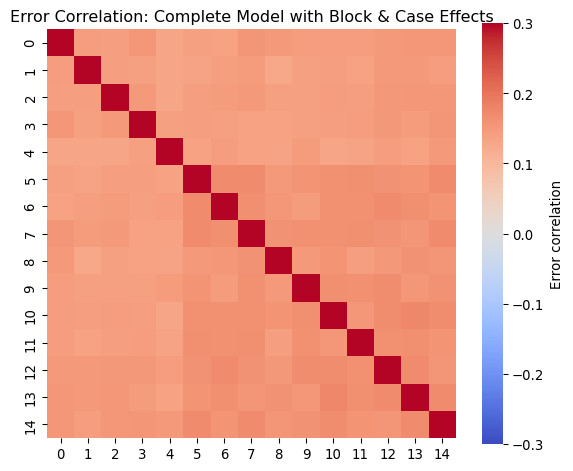

In [15]:
def run_ppc_full_model(idata, n_cases, true_states, block_id, 
                       jury_sizes=JURY_SIZES, n_draws=500):
    """
    PPC for complete model including block and case effects.
    Properly samples from posterior distribution.
    """
    # Extract posterior samples
    alpha_j = idata.posterior['alpha_j'].stack(sample=("chain", "draw")).values
    block_effect = idata.posterior['block_effect'].stack(sample=("chain", "draw")).values
    sigma_case = idata.posterior['sigma_case'].stack(sample=("chain", "draw")).values
    mu_case = idata.posterior['mu_case'].stack(sample=("chain", "draw")).values
    trt = idata.posterior['trt'].stack(sample=("chain", "draw")).values
    
    n_jurors = alpha_j.shape[0]
    total_samples = alpha_j.shape[1]
    
    # Randomly select n_draws samples
    sample_idx = np.random.choice(total_samples, size=min(n_draws, total_samples), 
                                 replace=False)
    n_draws = len(sample_idx)
    
    results = {
        'majority_acc': np.zeros(n_draws),
        'error_corr': np.zeros((n_draws, n_jurors, n_jurors)),
        'accuracy_by_size': {k: np.zeros(n_draws) for k in jury_sizes}
    }
    
    rng = np.random.default_rng(42)
    
    for idx, s in enumerate(sample_idx):
        # Sample case difficulty effects for this posterior draw
        delta_case = rng.normal(mu_case[s], sigma_case[s], size=n_cases)
        
        # Generate votes for each case
        votes = np.zeros((n_cases, n_jurors), dtype=int)
        
        for i in range(n_cases):
            truth_i = true_states[i]
            sign = 1 if truth_i == 1 else -1
            
            for j in range(n_jurors):
                # Combine individual skill + block effect + case difficulty
                logit_p = sign * (alpha_j[j, s] + block_effect[block_id[j], s]) + delta_case[i] + trt[j, s]
                p = 1 / (1 + np.exp(-logit_p))
                votes[i, j] = rng.binomial(1, p)
        
        # Compute diagnostics
        diag = compute_diagnostics(votes, true_states)
        results['majority_acc'][idx] = diag['majority_accuracy']
        results['error_corr'][idx] = diag['error_corr']
        
        for k in jury_sizes:
            results['accuracy_by_size'][k][idx] = (
                majority_accuracy_by_size(votes, true_states, k)
            )
    
    return results


print("\nRunning posterior predictive checks for complete model...")
ppc_full = run_ppc_full_model(idata_full, N_CASES, true_states_blocked, 
                               BLOCK_ID, n_draws=500)

# Summarize accuracy by jury size
summary_full = summarize_ppc(ppc_full)
print("\n" + "="*70)
print("MAJORITY ACCURACY BY JURY SIZE (Complete Model)")
print("="*70)
print(summary_full)

# Plot error correlations
plot_error_correlation_heatmap(
    ppc_full,
    title="Error Correlation: Complete Model with Block & Case Effects"
)

print("\n" + "="*70)
print("ERROR CORRELATION SUMMARY (Complete Model)")
print("="*70)
error_summary = summarize_error_correlation(ppc_full)
for key, value in error_summary.items():
    print(f"{key}: {value:.3f}")

Notice the structured patterns in the error correlation heatmap—jurors within the same block (0-4, 5-10, 11-14) show correlated errors. This is the smoking gun: **block effects create dependencies that violate the independence assumption**.

Let's visualize how much this matters:


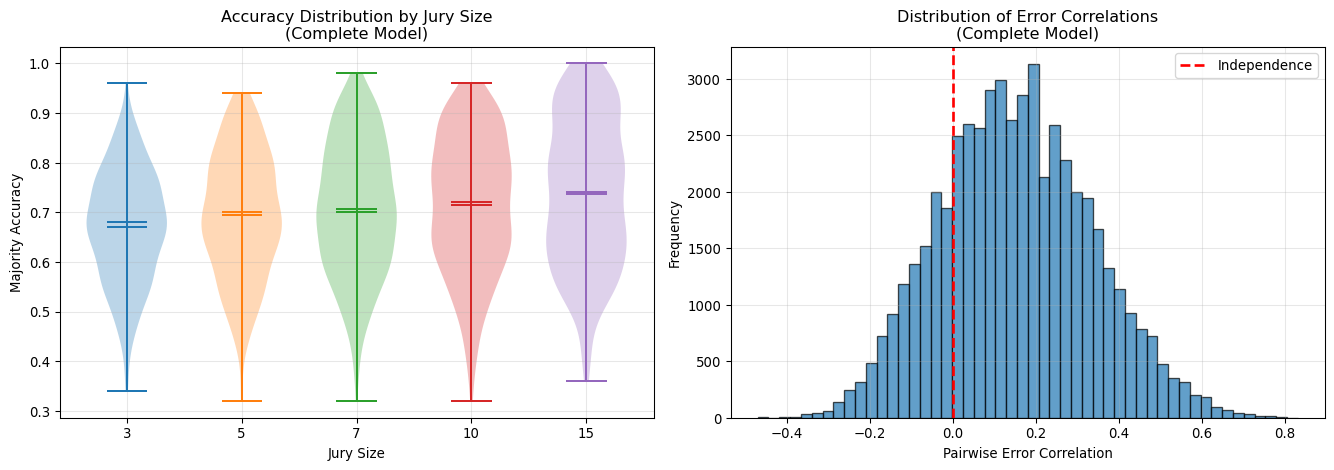


QUANTIFYING THE VIOLATION
Mean error correlation: nan
Proportion of positive correlations: 78.4%

Median accuracy (15 jurors): 0.740
Median accuracy (3 jurors): 0.680
Improvement from larger jury: 0.060


In [16]:
# Compare accuracy distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by jury size
ax = axes[0]
jury_size_labels = [3, 5, 7, 10, 15]
for i, size in enumerate(jury_size_labels):
    accuracies = ppc_full['accuracy_by_size'][size]
    ax.violinplot([accuracies], positions=[i], widths=0.7, 
                   showmeans=True, showmedians=True)

ax.set_xticks(range(len(jury_size_labels)))
ax.set_xticklabels(jury_size_labels)
ax.set_xlabel('Jury Size')
ax.set_ylabel('Majority Accuracy')
ax.set_title('Accuracy Distribution by Jury Size\n(Complete Model)')
ax.grid(True, alpha=0.3)

# Plot 2: Error correlation distribution
ax = axes[1]
off_diag_corrs = []
for s in range(ppc_full['error_corr'].shape[0]):
    mat = ppc_full['error_corr'][s]
    n = mat.shape[0]
    off_diag_corrs.extend(mat[np.triu_indices(n, k=1)])

ax.hist(off_diag_corrs, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Independence')
ax.set_xlabel('Pairwise Error Correlation')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Error Correlations\n(Complete Model)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate the impact on the Condorcet theorem
print("\n" + "="*70)
print("QUANTIFYING THE VIOLATION")
print("="*70)
print(f"Mean error correlation: {np.mean(off_diag_corrs):.3f}")
print(f"Proportion of positive correlations: {(np.array(off_diag_corrs) > 0).mean():.1%}")
print(f"\nMedian accuracy (15 jurors): {np.median(ppc_full['accuracy_by_size'][15]):.3f}")
print(f"Median accuracy (3 jurors): {np.median(ppc_full['accuracy_by_size'][3]):.3f}")
print(f"Improvement from larger jury: {np.median(ppc_full['accuracy_by_size'][15]) - np.median(ppc_full['accuracy_by_size'][3]):.3f}")

```

# Conclusions

Through systematic sensitivity analysis, we've identified three critical failure modes for democratic aggregation:

1. **Heterogeneous Competence**: Individual differences alone don't break the Condorcet theorem, but they do create inequality in influence. A few highly competent jurors can dominate.

2. **Shared Difficulties**: When cases vary in difficulty—especially systematically—jurors make correlated errors. This is the most severe violation: it directly undermines the statistical power of aggregation.

3. **Group Effects**: Ideological factions, information silos, and social clustering create structured dependence. Jurors no longer provide independent evidence.

The Condorcet Jury Theorem remains a powerful ideal, but its assumptions are fragile. Real-world collective decision-making must account for:
- Training and expertise development (reduce heterogeneity)
- Procedural safeguards against groupthink (break dependencies)
- Recognition of case difficulty (adjust decision rules)
- Diverse information sources (counteract block effects)

Democracy works—but only when we actively work to satisfy its preconditions.